In [13]:
import pennylane as qml
from pennylane import numpy as np
from lecture08_helpers import *

import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs

In [14]:
n_samples = 100

X, y = make_blobs(
    n_samples=n_samples, 
    centers=[[0.1, 0.2], [0.25, 0.4]], 
    cluster_std=0.05, 
    n_features=2,
    random_state=6
)

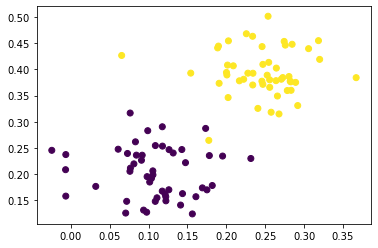

In [15]:
plot_data(X, y)

In [16]:
X = np.array(X, requires_grad=False)
y = np.array(y, requires_grad=False)
y[y == 0] = -1

<h1>
    VQC
</h1>

In [17]:
dev = qml.device('default.qubit', wires=2)

@qml.qnode(dev)
def model_2(point, weights):
    qml.AngleEmbedding(point, wires=[0, 1])
    qml.Rot(*weights[0], wires=0)
    qml.Rot(*weights[1], wires=1)
    qml.CNOT(wires=[1, 0])
    return qml.expval(qml.PauliX(0))

In [18]:
weights = np.random.normal(size=(2, 3), requires_grad=True)
weights

tensor([[-1.02318462,  0.69801034, -1.92376469],
        [ 1.66109505, -0.81365136,  1.59955547]], requires_grad=True)

In [19]:
print(qml.draw(model_2, expansion_strategy="device")(X[0], weights))

0: ──RX(0.12)──Rot(-1.02,0.70,-1.92)─╭X─┤  <X>
1: ──RX(0.25)──Rot(1.66,-0.81,1.60)──╰●─┤     


In [20]:
loss = make_loss_function(X, y, model_2)

In [21]:
opt = qml.GradientDescentOptimizer(stepsize=0.1)

n_its = 100

loss_track = []

for it in range(n_its):
    weights, _loss = opt.step_and_cost(loss, weights)
    if it % 5 == 0:
        our_preds = make_predictions(X, model_2, weights)
        print(f"Loss at iteration {it} = {_loss}  Accuracy = {compute_accuracy(our_preds, y)}")
    loss_track.append(_loss)

Loss at iteration 0 = 1.1002750222525466  Accuracy = 0.5
Loss at iteration 5 = 1.0633751293856755  Accuracy = 0.5
Loss at iteration 10 = 1.0363118118811794  Accuracy = 0.5
Loss at iteration 15 = 1.0127547157353027  Accuracy = 0.5
Loss at iteration 20 = 0.9909063924215027  Accuracy = 0.5
Loss at iteration 25 = 0.9705653166553938  Accuracy = 0.5
Loss at iteration 30 = 0.952104778896501  Accuracy = 0.51
Loss at iteration 35 = 0.9359752643462029  Accuracy = 0.55
Loss at iteration 40 = 0.9224229438162045  Accuracy = 0.78
Loss at iteration 45 = 0.9113921865545285  Accuracy = 0.86
Loss at iteration 50 = 0.9025889624738241  Accuracy = 0.9
Loss at iteration 55 = 0.8956184320097893  Accuracy = 0.93
Loss at iteration 60 = 0.8901005841699444  Accuracy = 0.95
Loss at iteration 65 = 0.8857232702247139  Accuracy = 0.94
Loss at iteration 70 = 0.8822463033015463  Accuracy = 0.93
Loss at iteration 75 = 0.8794858709666571  Accuracy = 0.94
Loss at iteration 80 = 0.8772982120230701  Accuracy = 0.94
Loss at

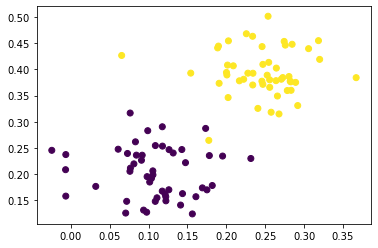

In [22]:
our_preds = make_predictions(X, model_2, weights)
plot_data(X, y)

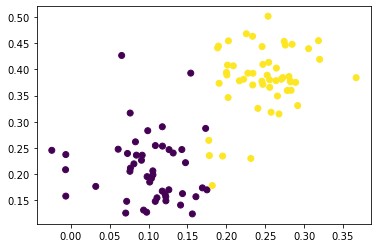

In [23]:
plot_data(X, our_preds)

In [24]:
compute_accuracy(our_preds, y)

0.94

<h1>
    Steps
</h1>

<img src="pics/RFF1-steps.png" width="480" height="240"/>


In [26]:
# print(weights)
# coeffs = weights

In [ ]:
# 1. Diagonalize the Hamiltonians of the above VQC

# obs = [qml.PauliX(0) @ qml.PauliZ(1), qml.PauliZ(0) @ qml.Hadamard(2)]
# H = qml.Hamiltonian(coeffs, obs)